In [1]:
using FFTW, LinearAlgebra
using BenchmarkTools
using Plots
gr()

Plots.GRBackend()

DataSet

In [15]:
function ftau(
        m      :: MicMac, 
        t      :: Float64, 
        fft_u  , fft_v  )

    llambda  = m.data.llambda
    sigma    = m.data.sigma
    conjmatr = conj.(m.matr)

    if ndims(fft_u) == 1 
        u = transpose(ifft(exp.(1im * t * m.A1) .* fft_u)) .* m.matr
    else
        u = ifft(transpose(exp.(1im * t * m.A1)) .* fft_u, 2) .* m.matr
    end
        
    if ndims(fft_v) == 1 
        v = transpose(ifft(exp.(1im * t * m.A1) .* fft_v)) .* m.matr
    else
        v = ifft(transpose(exp.(1im * t * m.A1)) .* fft_v, 2) .* m.matr
    end
        

    z = ( u .+ conj.(v)) / 2

    fz1  = abs.(z) .^ (2*sigma) .* z

    champu = transpose(-1im * llambda * m.A2 .* exp.(-1im * t * m.A1)) .* fft(conjmatr .* fz1, 2)
    champv = transpose(-1im * llambda * m.A2 .* exp.(-1im * t * m.A1)) .* fft(conjmatr .* conj.(fz1), 2)

    champu, champv
end

ftau (generic function with 1 method)

In [16]:
function ftau!(champu, champv, m, t)
    
    llambda  = m.data.llambda
    sigma    = m.data.sigma
    conjmatr = conj.(m.matr)
    
    champu .*= transpose(exp.(1im * t * m.A1))
    champv .*= transpose(exp.(1im * t * m.A1))
    
    ifft!(champu, 2)
    ifft!(champv, 2)

    champu .*= m.matr
    champv .*= m.matr

    z = (champu .+ conj.(champv)) / 2

    fz1 = abs.(z) .^ (2 * sigma) .* z
    
    champu .= conjmatr .* fz1
    champv .= conjmatr .* conj.(fz1)

    fft!(champu, 2)
    fft!(champv, 2)

    champu .*= transpose(-1im * llambda * m.A2 .* exp.(-1im * t * m.A1))
    champv .*= transpose(-1im * llambda * m.A2 .* exp.(-1im * t * m.A1))

end

ftau! (generic function with 1 method)

In [17]:
function C1!(
        champu :: Array{ComplexF64,2},
        champv :: Array{ComplexF64,2}, 
        m      :: MicMac, 
        t      :: Float64, 
        fft_u  :: Vector{ComplexF64}, 
        fft_v  :: Vector{ComplexF64}) 

    champu, champv = ftau( m, t, fft_u, fft_v)

    fft!(champu, 1)
    fft!(champv, 1)

    champu[1, :] .= 0.0
    champv[1, :] .= 0.0

    champu ./= (1im * m.ktau)
    champv ./= (1im * m.ktau)

    ifft!(champu, 1)
    ifft!(champv, 1)

    epsilon   = m.data.epsilon

    champu .= transpose(fft_u) .+ epsilon * champu
    champv .= transpose(fft_v) .+ epsilon * champv

end

C1! (generic function with 1 method)

In [18]:
function duftau(
        m      :: MicMac, 
        t      :: Float64, 
        fft_u  :: Vector{ComplexF64}, 
        fft_v  :: Vector{ComplexF64}, 
        fft_du :: Vector{ComplexF64}, 
        fft_dv :: Vector{ComplexF64})

    sigma    = 1
    llambda  = m.data.llambda
    matr     = m.matr
    conjmatr = conj.(matr)

    u = ifft(transpose(exp.(1im * t .* m.A1) .* fft_u) .* matr, 2)
    v = ifft(transpose(exp.(1im * t .* m.A1) .* fft_v) .* matr, 2)

    du = ifft(transpose(exp.(1im * t .* m.A1) .* fft_du) .* matr, 2)
    dv = ifft(transpose(exp.(1im * t .* m.A1) .* fft_dv) .* matr, 2)

    z  = (u  .+ conj.(v) ) / 2
    dz = (du .+ conj.(dv)) / 2

    fz1 = 2 * abs.(z) .^ 2 .* dz .+ z .^ 2 .* conj.(dz)

    champu = transpose(-1im * llambda * m.A2 .* exp.(-1im * t .* m.A1)) .* fft(conjmatr .* fz1, 2)
    champv = transpose(-1im * llambda * m.A2 .* exp.(-1im * t .* m.A1)) .* fft(conjmatr .* conj.(fz1), 2)

    champu, champv

end

duftau (generic function with 1 method)

In [19]:
function dtftau!(
        champu :: Array{ComplexF64,2},
        champv :: Array{ComplexF64,2},
        m      :: MicMac, 
        t      :: Float64, 
        fft_u  :: Vector{ComplexF64}, 
        fft_v  :: Vector{ComplexF64} )

    sigma    = 1
    llambda  = m.data.llambda
    conjmatr = conj.(m.matr)

    champu  .= transpose(exp.(1im * t .* m.A1) .* fft_u).* m.matr
    champv  .= transpose(exp.(1im * t .* m.A1) .* fft_v).* m.matr

    ifft!(champu, 2)
    ifft!(champv, 2)
    
    z  = (champu  .+ conj.(champv) ) / 2

    champu .= transpose(ifft(exp.(1im * t .* m.A1) .* (1im .* m.A1) .* fft_u)) .* m.matr
    champv .= transpose(ifft(exp.(1im * t .* m.A1) .* (1im .* m.A1) .* fft_v)) .* m.matr

    dz = (champu .+ conj.(champv)) / 2

    fz1 = 2 * abs.(z) .^ 2 .* dz .+ z .^ 2 .* conj.(dz)
    
    champu .= transpose(-1im * llambda * m.A2 .* exp.(-1im * t .* m.A1)) .* fft(conjmatr .* fz1, 2)
    champv .= transpose(-1im * llambda * m.A2 .* exp.(-1im * t .* m.A1)) .* fft(conjmatr .* conj.(fz1), 2)

    fz1 = abs.(z) .^ 2 .* z
    
    champu .+= transpose(-1im * llambda * m.A2 .* exp.(-1im * t * m.A1) .* (-1im * m.A1)) .* fft(conjmatr .* fz1, 2)
    champv .+= transpose(-1im * llambda * m.A2 .* exp.(-1im * t * m.A1) .* (-1im * m.A1)) .* fft(conjmatr .* conj.(fz1), 2)

end

dtftau! (generic function with 1 method)

In [20]:
function init_2!(champu, champv, m, t,
                 fft_ubar, fft_vbar, fft_ug, fft_vg)


    champu, champv = ftau(m, t, fft_ubar, fft_vbar)

    fft!(champu, 1)
    fft!(champv, 1)

    champu[1, :] .= 0.0
    champv[1, :] .= 0.0
    
    champu ./= (1im * m.ktau)
    champv ./= (1im * m.ktau)
    
    ifft!(champu, 1)
    ifft!(champv, 1)

    fft_ubar .= fft_ubar .- m.data.epsilon * champu[1, :]
    fft_vbar .= fft_vbar .- m.data.epsilon * champv[1, :]

    C1!( champu, champv, m, t, fft_ubar, fft_vbar)

    fft_ug .= fft_ug .- champu[1, :]
    fft_vg .= fft_vg .- champv[1, :]

    
end

init_2! (generic function with 1 method)

In [21]:
function champs_2(champu, champv, m :: MicMac, t, fft_ubar, fft_vbar, fft_ug, fft_vg)

    sigma    = 1
    llambda  = m.data.llambda
    epsilon  = m.data.epsilon
    matr     = m.matr
    conjmatr = conj.(matr)
    nx       = m.data.nx

    champu, champv = ftau( m, t, fft_ubar, fft_vbar)

    fft!(champu, 1)
    fft!(champv, 1)

    champu[1, :] .= 0.0
    champv[1, :] .= 0.0

    dtauh1u = ifft(champu, 1)
    dtauh1v = ifft(champv, 1)

    h1u = epsilon * ifft(champu ./ (1im * m.ktau), 1)
    h1v = epsilon * ifft(champv ./ (1im * m.ktau), 1)

    champu .= transpose(fft_ubar) .+ h1u
    champv .= transpose(fft_vbar) .+ h1v
       
    ffu, ffv = ftau( m, t, champu .+ transpose(fft_ug), champv .+ transpose(fft_vg))

    ftau!( champu, champv, m, t)

    fft!(champu, 1)
    fft!(champv, 1)
    
    champubaru = similar(fft_ubar)
    champubarv = similar(fft_vbar)

    champubaru .= champu[1, :] ./ m.ntau
    champubarv .= champv[1, :] ./ m.ntau

    champu1, champv1 = duftau(m, t, fft_ubar, fft_vbar, champubaru, champubarv)
    dtftau!(champu, champv, m, t, fft_ubar, fft_vbar)

    champu .+= champu1 
    champv .+= champv1 
    
    fft!(champu, 1)
    fft!(champv, 1)

    champu[1, :] .= 0.0
    champv[1, :] .= 0.0

    champu .= transpose(champubaru) .+ epsilon * ifft(champu ./ (1im * m.ktau), 1)
    champv .= transpose(champubarv) .+ epsilon * ifft(champv ./ (1im * m.ktau), 1)

    champu .= ffu .- dtauh1u .- champu
    champv .= ffv .- dtauh1v .- champv

    fft!(champu, 1)
    fft!(champv, 1)

    champmoyu = zeros(ComplexF64,nx)
    champmoyv = zeros(ComplexF64,nx)
    
    champmoyu .= champu[1, :] ./ m.ntau
    champmoyv .= champv[1, :] ./ m.ntau

    champu[1, :] .= 0.0 
    champv[1, :] .= 0.0

    champu .= champu ./ (1im * m.ktau)
    champv .= champv ./ (1im * m.ktau)

    ifft!(champu, 1)
    ifft!(champv, 1)

    champubaru, champubarv, champu, champv, champmoyu, champmoyv

end

champs_2 (generic function with 1 method)

reconstr (generic function with 1 method)

In [23]:
function solve(m :: MicMac, dt)

    Tfinal    = m.data.Tfinal
    nx        = m.data.nx
    ntau      = m.ntau
    T         = m.data.T
    kx        = m.data.kx

    fft_u = zeros(ComplexF64,nx)
    fft_v = zeros(ComplexF64,nx)

    fft_u .= m.data.u
    fft_v .= m.data.v

    fft_ubar    = similar(fft_u)
    fft_vbar    = similar(fft_v)
    fft_ubar12  = similar(fft_u)
    fft_vbar12  = similar(fft_v)

    fft_ug      = similar(fft_u)
    fft_vg      = similar(fft_v)
    fft_ug12    = similar(fft_u)
    fft_vg12    = similar(fft_v)
    fft_ugbar12 = similar(fft_u)
    fft_vgbar12 = similar(fft_v)

    champu = zeros(ComplexF64,(ntau,nx))
    champv = zeros(ComplexF64,(ntau,nx))
    
    ichampu = zeros(ComplexF64,(ntau,nx))
    ichampv = zeros(ComplexF64,(ntau,nx))

    epsilon   = m.data.epsilon
    dx        = m.data.dx
    llambda   = m.data.llambda
    sigma     = m.data.sigma

    t    = 0.0
    iter = 0

    fft!(fft_u)
    fft!(fft_v)
    
    fft_ubar .= fft_u
    fft_vbar .= fft_v
    fft_ug   .= fft_u
    fft_vg   .= fft_v

    init_2!(champu, champv, m, t, fft_ubar, fft_vbar, fft_ug, fft_vg)

    while t < Tfinal

        iter += 1
        dt    = min(Tfinal-t, dt)

        champubaru, champubarv, ichampgu, ichampgv, champmoyu, champmoyv = ( 
            champs_2(champu, champv, m, t, 
                     fft_ubar, fft_vbar, fft_ug, fft_vg) )

        fft_ubar12 .= fft_ubar .+ dt/2 * champubaru
        fft_vbar12 .= fft_vbar .+ dt/2 * champubarv

        fft_ug12  .= (fft_ug 
	              .+ epsilon * reconstr(ichampgu, (t+dt/2)/epsilon, T, ntau) 
                  .- epsilon * reconstr(ichampgu, t/epsilon, T, ntau) 
                  .+ dt/2 * champmoyu)

        fft_vg12  .= (fft_vg 
                  .+ epsilon * reconstr(ichampgv, (t+dt/2)/epsilon, T, ntau) 
                  .- epsilon * reconstr(ichampgv, t/epsilon, T, ntau) 
                  .+ dt/2 * champmoyv)

        champubaru, champubarv, ichampgu, ichampgv, champmoyu, champmoyv = (
            champs_2(champu, champv, m, t+dt/2, 
                     fft_ubar12, fft_vbar12, fft_ug12, fft_vg12))

        fft_ubar .+= dt * champubaru
        fft_vbar .+= dt * champubarv
        
        fft_ug .= ( fft_ug 
               .+ epsilon * reconstr(ichampgu, (t+dt)/epsilon, T, ntau) 
               .- epsilon * reconstr(ichampgu, t/epsilon, T, ntau) 
               .+ dt * champmoyu )
        
        fft_vg .= ( fft_vg
               .+ epsilon * reconstr(ichampgv, (t+dt)/epsilon, T, ntau) 
               .- epsilon * reconstr(ichampgv, t/epsilon, T, ntau) 
               .+ dt * champmoyv )
        
        t += dt
        
        C1!(champu, champv, m, t, fft_ubar, fft_vbar)
        
        fft_u .= reconstr(champu, t / epsilon, T, ntau)
        fft_v .= reconstr(champv, t / epsilon, T, ntau)
        
        fft_u .+= fft_ug
        fft_v .+= fft_vg

    end

    fft_u .= exp.(1im * sqrt.(1 .+ epsilon * kx.^2) * t / epsilon) .* fft_u
    fft_v .= exp.(1im * sqrt.(1 .+ epsilon * kx.^2) * t / epsilon) .* fft_v

    ifft!(fft_u)
    ifft!(fft_v)

    fft_u, fft_v

end

solve (generic function with 1 method)

In [24]:
function reconstr_x(uv, x)
    N  = size(uv)[2]
    nx = size(x)[1]
    L  = x[end] - x[1]
    UA = zeros(ComplexF64, (4, nx))
    v  = fft(uv, 2) / N
    for jj in 1:N÷2
        vv = v[:, jj]
        UA .= UA .+ vv .* exp.(1im * 2 * pi / L * (jj-1) * (x' .- xmin))
    end
    
    for jj in N÷2:N
        vv = v[:, jj]
        UA = UA .+ vv .* exp.(1im * 2 * pi / L * (jj-1-N) * (x' .- xmin))
    end

    UA
end

reconstr_x (generic function with 1 method)

compute_error (generic function with 1 method)

  5.781026 seconds (5.93 M allocations: 1.041 GiB, 3.64% gc time)
test/donnees_data3_128_micmac/donnee_0_1.txt
6.990606448983292
 error = 1.2725264318258103 
4.319129319867873


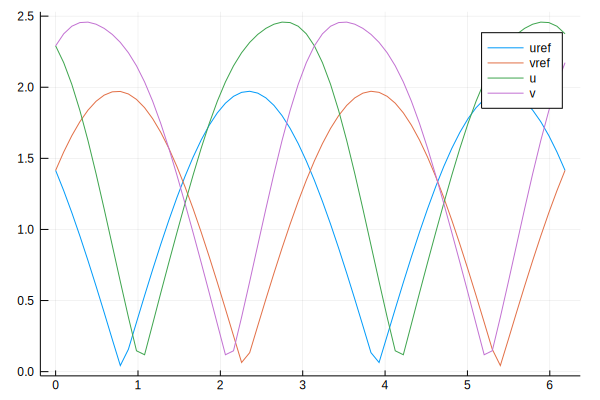

In [26]:
dataset  = 3
xmin     = 0
xmax     = 2π
T        = 2π
nx       = 64
ntau     = 32
tfinal   = 0.25
epsilon  = 0.1

data = DataSet(dataset, xmin, xmax, nx, epsilon, tfinal)

dt = 2.0^(-3) * tfinal / 16

m = MicMac(data, ntau)

@time u, v = solve(m, dt)

uref, vref = compute_error(u, v, data)

println(maximum(abs.(u .- uref)) + maximum(abs.(v .- vref)))

plot( data.x, abs.(uref), label=:uref)
plot!(data.x, abs.(vref), label=:vref)
plot!(data.x, abs.(u), label=:u)
plot!(data.x, abs.(v), label=:v)

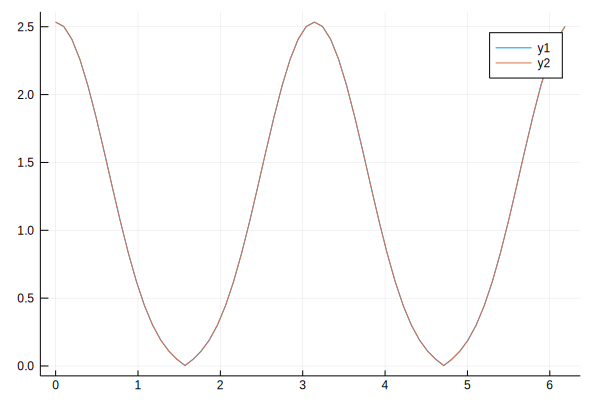

In [27]:
u = data.u
v = data.v
champu = zeros(ComplexF64,(ntau, nx))
champv = zeros(ComplexF64,(ntau, nx))
champu, champv = ftau( m, 0.0, fft(u), fft(v))
fft_u = reconstr(champu, dt / epsilon, T, ntau)
fft_v = reconstr(champv, dt / epsilon, T, ntau)
plot(data.x,  abs.(ifft(fft_u))) 
plot!(data.x, abs.(ifft(fft_v)))

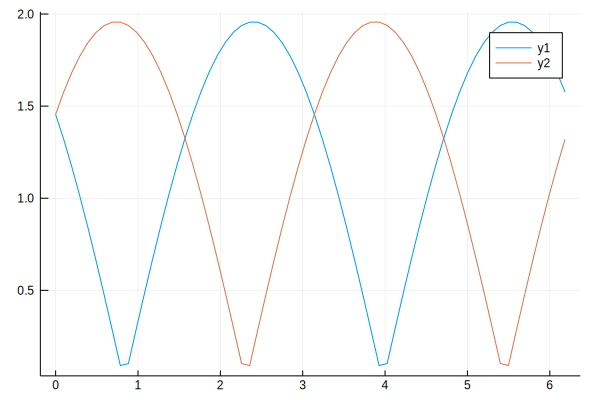

In [57]:
fft_ubar = similar(u)
fft_vbar = similar(v)
fft_ug = similar(u)
fft_vg = similar(v)

fft_ubar = fft(u)
fft_vbar = fft(v)
fft_ug = fft(u)
fft_vg = fft(v)

init_2!(champu, champv, m, 0.0,
                 fft_ubar, fft_vbar, fft_ug, fft_vg)

plot(data.x, abs.(ifft(fft_ubar))) 
plot!(data.x, abs.(ifft(fft_vbar)))

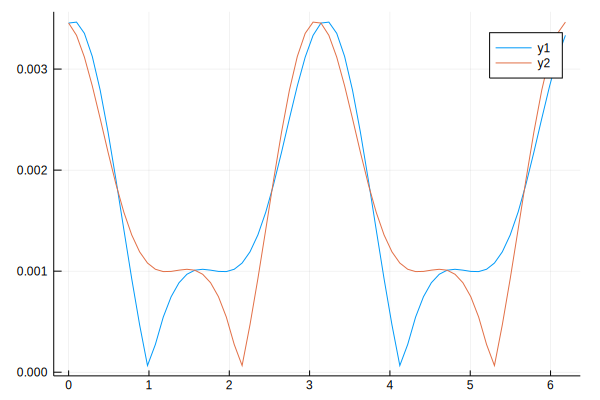

In [58]:
plot(data.x, abs.(ifft(fft_ug)))
plot!(data.x, abs.(ifft(fft_vg)))

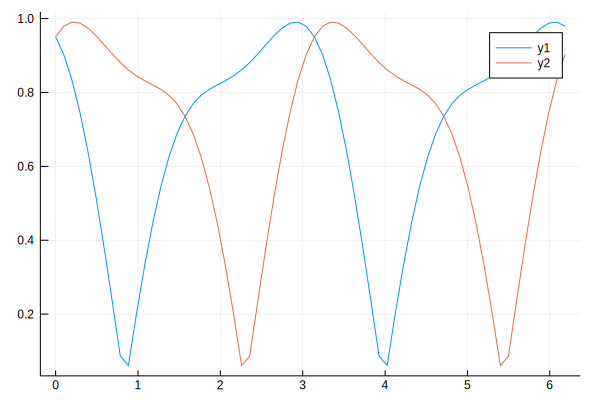

In [59]:
champubaru, champubarv, ichampgu, ichampgv, champmoyu, champmoyv = (
            champs_2(champu, champv, m, dt/epsilon, 
                     fft_ubar, fft_vbar, fft_ug, fft_vg))

plot(data.x, abs.(ifft(champubaru))) 
plot!(data.x, abs.(ifft(champubarv)))


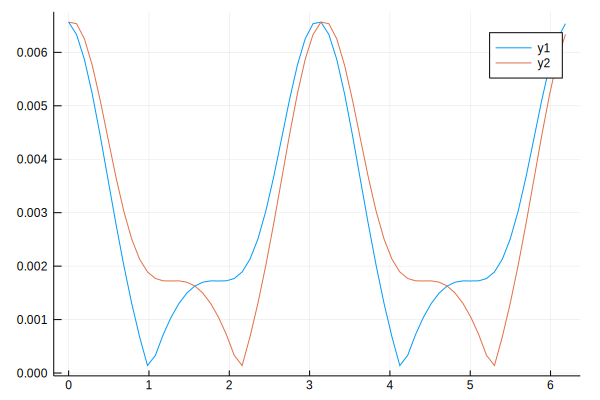

In [60]:
plot(data.x, abs.(ifft(champmoyu)))
plot!(data.x, abs.(ifft(champmoyv)))

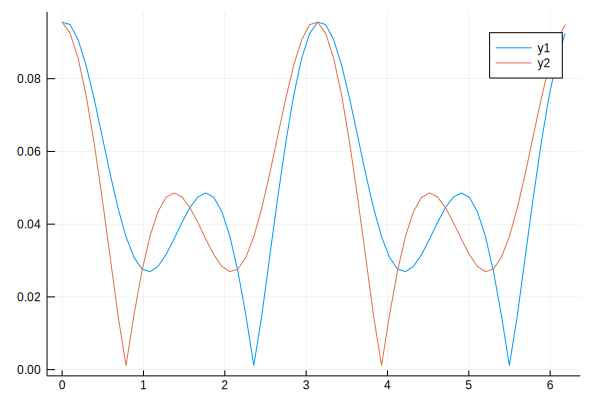

In [61]:
fft_u = reconstr(ichampgu, dt / epsilon, T, ntau)
fft_v = reconstr(ichampgv, dt / epsilon, T, ntau)
plot(data.x, abs.(ifft(fft_u)))
plot!(data.x, abs.(ifft(fft_v)))